In [1]:
# which test to look at?
iExpToLookAt = 5
if iExpToLookAt==1:
    strSaveState='MouseQPCR_Exp1' #Exp1: Est Z, Est theta, Soft 
elif iExpToLookAt==2: 
    strSaveState='MouseQPCR_Exp2' #Exp2: Est Z, Est theta, Est Z, Soft
elif iExpToLookAt==3: 
    strSaveState='MouseQPCR_Exp3' #Exp3: Est Z, Est theta, Hard
elif iExpToLookAt==4: 
    strSaveState='MouseQPCR_Exp4' #Exp4: Est Z, Est theta, Est Z, Hard
elif iExpToLookAt==5: 
    strSaveState='MouseQPCR_Exp5' #Exp5: Est Z, Soft
elif iExpToLookAt==6: 
    strSaveState='MouseQPCR_Exp6' #Exp6: Est Z, Hard (Not done)
    
print 'Loading ' + strSaveState

Loading MouseQPCR_Exp5


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import GPflow
import numpy as np
import tensorflow as tf
np.set_printoptions(precision=4) # precision to print numpy array
import time
import cPickle as pickle


import AssignGPGibbsSingleLoop
import branch_kernParamGPflow as bk
import assigngp_dense 
import BranchingTree as bt

seed = 43

np.random.seed(seed=seed) # easy peasy reproducibeasy
tf.set_random_seed(seed)
import mouseQPCRModelSelection

In [3]:
pt,Y = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=0)
m,mV = mouseQPCRModelSelection.InitModels(pt,Y)

Loaded data data/guo_ssData.p with nrowsXncols = (437, 2).
(437, 2)
(437,)
LoadMouseQPCRData output
(437, 2)
(437,)
Branching kernel =====================
unnamed.white.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.\u001bBv\u001b transform:(none) prior:None [FIXED]
[[ 1.]]
Initialise models: MAP =====================
model.kern.white.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.\u001bBv\u001b transform:(none) prior:None [FIXED]
[[ 1.]]
model.likelihood.\u001bvariance\u001b transform:+ve prior:None
[ 1.]

Initialise models: VB =====================
compiling tensorflow function...

In [4]:
saveDict = pickle.load( open( 'modelfiles/'+strSaveState + '_Summary.p', "rb" ) )
print saveDict
logVBBound = saveDict['logVBBound']
logLike = saveDict['logLike']
Bpossible = saveDict['Bpossible']

{'logVBBound': [array([ 418.8838]), array([ 425.2341]), array([ 425.0612]), array([ 426.4829]), array([ 430.4946]), array([ 439.5452]), array([ 444.1333]), array([ 450.9277]), array([ 458.6153]), array([ 478.1197]), array([ 504.1992]), array([ 525.4031]), array([ 536.0584]), array([ 542.1139]), array([ 549.4434]), array([ 566.1747]), array([ 591.7724]), array([ 614.4017]), array([ 640.4715]), array([ 664.8074]), array([ 689.1142]), array([ 742.1162])], 'logLike': [array([-1076.5165]), array([-1075.1954]), array([-1079.1196]), array([-1077.4875]), array([-1070.1319]), array([-1074.8942]), array([-1067.4415]), array([-1082.4129]), array([-1075.8265]), array([-1069.5657]), array([-1073.1681]), array([-1069.1587]), array([-1074.7925]), array([-1064.7728]), array([-1068.4545]), array([-1075.5589]), array([-1075.4876]), array([-1077.4794]), array([-1063.6683]), array([-1080.333]), array([-1076.7066]), array([-1091.6447])], 'Bpossible': array([  2.    ,   5.2381,   8.4762,  11.7143,  14.9524,

ML estimated B 60.2857142857 with likelihood [-1063.6683]


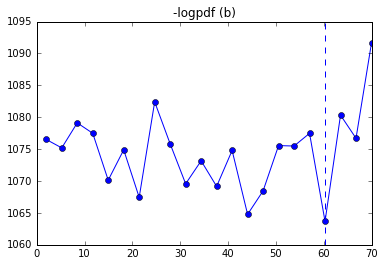

In [5]:
nlogL = -np.array(logLike)
iMin = np.argmin(nlogL)
plt.plot(Bpossible[:len(logLike)],nlogL, '-ob')
plt.title('-logpdf (b)')
v=plt.axis()
minB = Bpossible[iMin]
plt.plot([minB,minB],v[-2:],'--b')
print 'ML estimated B ' + str(minB) + ' with likelihood ' + str(logLike[iMin])

VB estimated B 2.0 with marginal likelihood [ 418.8838]


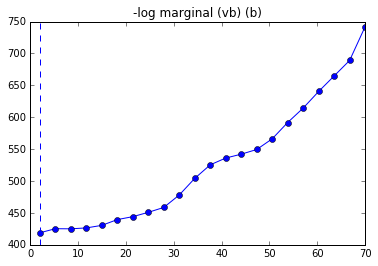

In [6]:
nlogL = np.array(logVBBound)
iMin = np.argmin(nlogL)
plt.plot(Bpossible[:len(logVBBound)],nlogL, '-ob')
plt.title('-log marginal (vb) (b)')

v=plt.axis()
minB = Bpossible[iMin]
plt.plot([minB,minB],v[-2:],'--b')

print 'VB estimated B ' + str(minB) + ' with marginal likelihood ' + str(logVBBound[iMin])

Processing B=2.00
Processing B=5.24


KeyboardInterrupt: 

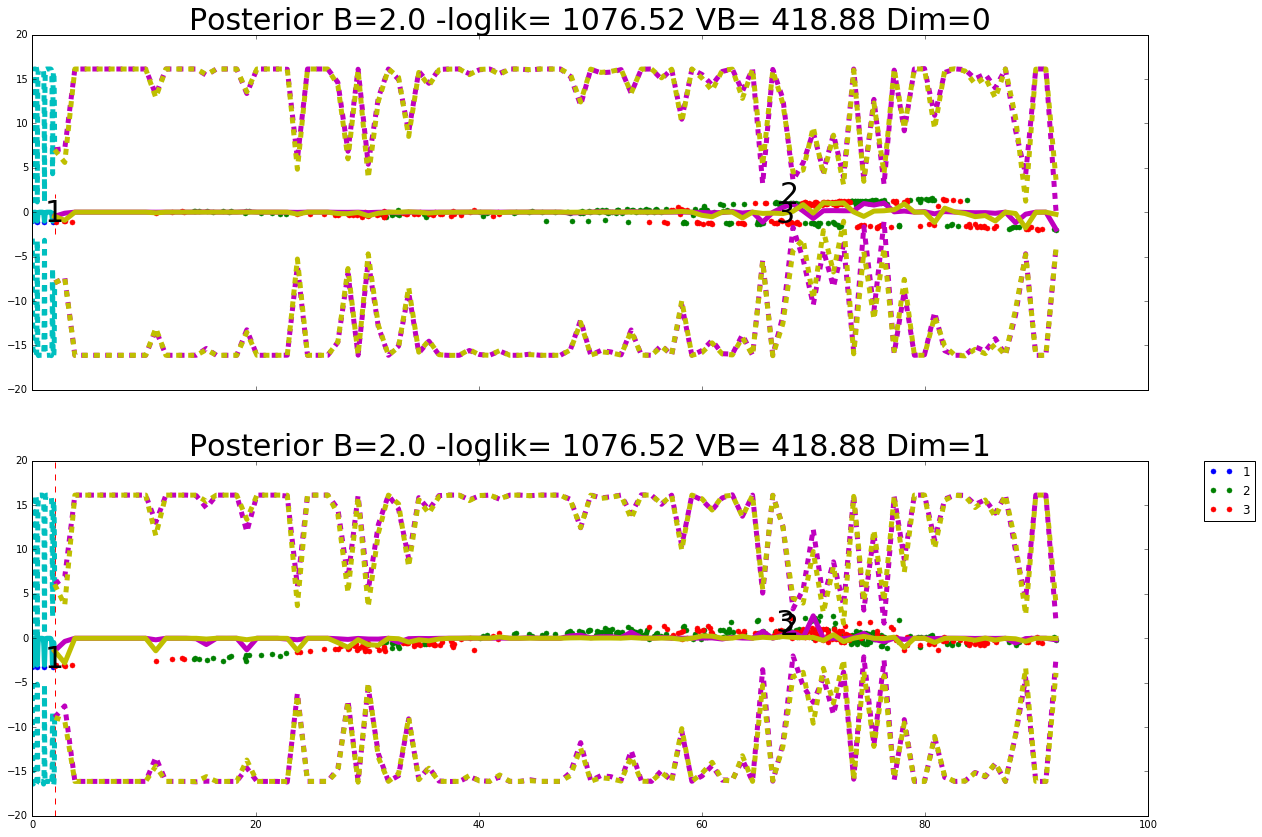

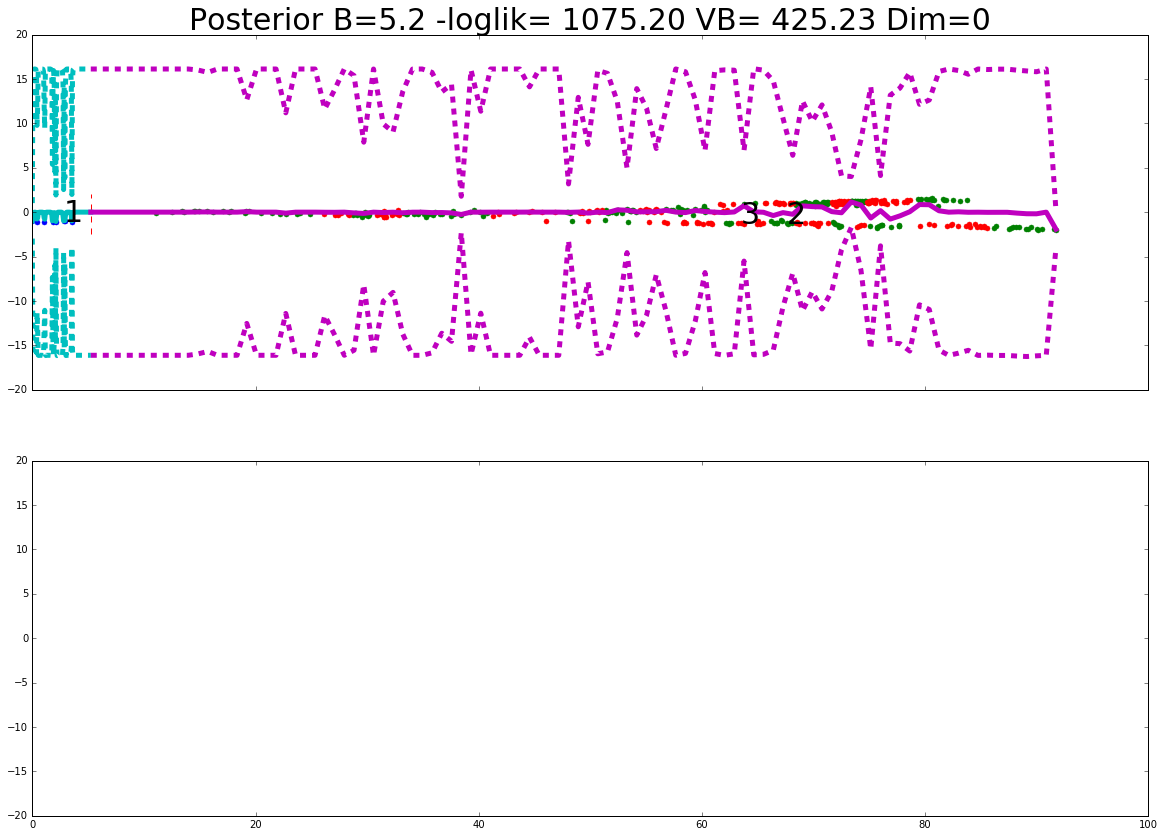

In [7]:
for ib, b in enumerate(Bpossible):
    Bcrap = np.atleast_2d(b) # crappy branch point
    if(np.isnan(logLike[ib])):
        print 'B='+str(b) + ' is nan.'
    else:
        print 'Processing B=%.2f'%b
        bestAssignment = np.load('modelfiles/'+strSaveState + '_b' + str(ib) + '_MAPModel.npy')

        # Load and copy in mV            
        mV.set_state(np.load('modelfiles/'+strSaveState + '_b' + str(ib) + '_VBmodel.npy'))

        assert np.all(mV.Y.shape == Y.shape)

        # need to explicitly set branching point as it is FIXED and not saved as part of the free state
        mV.kern.branchkernelparam.Bv = Bcrap 

        #print mV

        # plotting
        D = Y.shape[1]
        assigngp_dense.PlotSample(D,mV.X[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, \
                                  mV=mV, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,-logLike[ib],logVBBound[ib]))

